In [1]:
#All neccesary classes for project

#general
import seaborn as sns
import scipy.stats as ss
import pandas as pd
import numpy as np
import os
import pickle
import time
import sys

#for preprocessing
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import tensorflow as tf

#for machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

#for evaluation
from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score

#for utility packages
from Utilities.utilities import import_data
from Utilities.utilities import DataFrameSelector
from Utilities.utilities import CategoricalEncoder
from Utilities.utilities import display_scores
from Utilities.utilities import pipeline_transform
from Utilities.utilities import reset_graph
from Utilities.models import DNN_Model
from Utilities.models import cross_val_score_dnn
from functools import partial

#image manipulation
from PIL import Image as PI
from resizeimage import resizeimage
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
import imagenet_helper_files.vgg_preprocessing
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim.nets import resnet_v2
import imagenet_helper_files.pnasnet as nas

#Import Custom Functions
from Utilities.model_builder import get_image
from Utilities.model_builder import get_file_lists
from Utilities.model_builder import parse_record
from Utilities.model_builder import get_batch
from Utilities.model_builder import build_iterator
from Utilities.model_builder import build_dataset
from Utilities.bounded_model_builder import build_bounded_iterator
from Utilities.bounded_model_builder import build_bounded_iterator_points
from Utilities.model_builder import get_values_imagenet
from Utilities.model_builder import get_values_bounded
from Utilities.model_builder import get_values_bounded_points
from Utilities.models import log_dir_build
from Utilities.utilities import generate_image
from Utilities.utilities import generate_image_array
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset

from Utilities.utilities import get_ground_truth_string
from Utilities.utilities import find_new_imagenet_ground_truth_int
from Utilities.cell_net_predictor import Binary_Categorical_Predictor
from Utilities.build_image_data_notebook import process_dataset

from tan.tan_util import get_tan_nll as tan
from tan.tan_util import get_tan_nll_cond as tan_cond

Using TensorFlow backend.


# Load the Data

Here we will load the training and validation data in order to do training

In [2]:
#Build tf_records
#Set Variables
validation_directory = "D:/Machine_Learning/Datasets/airplane_vs_horse/validation"
train_directory = "D:/Machine_Learning/Datasets/airplane_vs_horse/train"
output_directory = "D:/Machine_Learning/Datasets/airplane_vs_horse/tf_records"
labels_file = "D:/Machine_Learning/Datasets/airplane_vs_horse/labels.txt"

num_threads = 2
num_shards = 2

In [ ]:
#make validation records
process_dataset('validation', validation_directory, num_shards, labels_file, num_threads, output_directory)

#make validation records
process_dataset('train', train_directory, num_shards, labels_file, num_threads, output_directory)

In [3]:
#Import TFRecords for both Training and Testing of the Dat
#Use the build_image_data.py to create these sets from your data
class_file = open(labels_file,'r')
class_list = class_file.read().split('\n')

train_list, val_list = get_file_lists(output_directory)
labels = class_list
labels

['airplane', 'horse']

In [4]:
validation_directory_all = "D:/Machine_Learning/Datasets/ten_class_classifier/validation"
train_directory_all = "D:/Machine_Learning/Datasets/ten_class_classifier/train"
output_directory_all = "D:/Machine_Learning/Datasets/ten_class_classifier/tf_records"
labels_file_all = "D:/Machine_Learning/Datasets/ten_class_classifier/labels.txt"


class_file_all = open(labels_file_all,'r')
class_list_all = class_file_all.read().split('\n')
train_list_all, val_list_all = get_file_lists(output_directory_all)
labels_all = class_list_all
labels_all

['airplane',
 'horse',
 'book',
 'cake',
 'car',
 'cat',
 'dog',
 'laptop',
 'pizza',
 'zebra']

In [ ]:
#make validation records
process_dataset('validation', validation_directory_all, num_shards, labels_file_all, num_threads, output_directory_all)

#make validation records
process_dataset('train', train_directory_all, num_shards, labels_file_all, num_threads, output_directory_all)

In [ ]:
#Build a workflow to extract the data 
reset_graph()

filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_element = iterator.get_next()
X, y, file = next_element


In [ ]:
class_0 = tf.where(tf.equal(y,0))
class_1 = tf.where(tf.equal(y,1))

c0_X=tf.gather_nd(X,class_0)
c1_X=tf.gather_nd(X,class_1)

c0_y=tf.gather_nd(y,class_0)
c1_y=tf.gather_nd(y,class_1)

X_cond_0 = tf.cond(training, lambda: c0_X, lambda: X)
X_cond_1 = tf.cond(training, lambda: c1_X, lambda: X)

output = tf.cond(tf.equal(0,0), lambda: tf.gather_nd(X, tf.where(tf.equal(y,0))),lambda: tf.gather_nd(X, tf.where(tf.equal(y,1)))  )

In [ ]:
#Test pulling a piece of data out of the set to ensure that records were created properly
with tf.Session() as sess:
    #saver2.restore(sess, landmark_ml_model)
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: 10, num_epochs:1})
    train_handle = sess.run(train_iterator.string_handle())
    
    
    X_cond_out_0, X_cond_out_1 = sess.run([X_cond_0, X_cond_1], feed_dict={handle: train_handle,training: True})

  

In [ ]:
out[0].shape

In [ ]:
X_val = single_file[0][0]
Y_val = single_file[0][1]
filename = single_file[0][2]
X_val.shape

In [ ]:
x_val = X_val.reshape(331,331,3)

from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.axis('off')
plt.show()


In [ ]:
labels_all[Y_val[0]]

In [ ]:
filename

# Build the Neural Network on top of Large Nas-Net

Here we will build the Nas-Net and then stack our own network on top

In [88]:

#import pnas_net model

#Nasnet Model Location
nas_net_model = 'D:/AI/models/pnas_net/model.ckpt'

out_of_set_net_logs = 'D:/AI/models/out_of_set_net_v2/logs'
model_path = log_dir_build(out_of_set_net_logs, "out_of_set_v2_tan")
out_of_set_net_model_class = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_class'
out_of_set_net_model_ae = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_ae'
out_of_set_net_model_tan = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_tan'
out_of_set_net_best = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_best'


In [5]:
#Reset the graph 
reset_graph()

#Set constants for Neural Network
dropout_rate = 0.3
learning_rate = 1
n_hidden1 = 2000
n_hidden2 = 1000
n_hidden3 = 500
n_hidden4 = 100
n_final_layer = 2

#Size of final Layer after CNN
cnn_code_layer_size = 4320

#For Decay
likely_batch_size = 30


"""
#Placeholder for input data
X = tf.placeholder(tf.float32, shape=[None, 331, 331, 3], name="input")
y = tf.placeholder(tf.float32, shape=[None,8], name="bounding_box")
"""

filename = tf.placeholder(tf.string, shape=[None], name="tf_records")
batch_size = tf.placeholder(tf.int64, shape=[], name= "Batch_Size")
num_epochs = tf.placeholder(tf.int64, shape=[], name= "Num_epochs")
training = tf.placeholder_with_default(True, shape=(), name = 'training')
handle = tf.placeholder(tf.string, shape=[], name="Dataset")

training_set = build_dataset(True, filename, batch_size, num_epochs, num_parallel_calls=8)
val_set = build_dataset(False, filename, batch_size, num_epochs, num_parallel_calls=8)

train_iterator = training_set.make_initializable_iterator()
val_iterator = val_set.make_initializable_iterator()



iterator = tf.data.Iterator.from_string_handle(
    handle, training_set.output_types, training_set.output_shapes)
next_data = iterator.get_next()
X, y, file = next_data


#Define initalizer and batch normalization layers
bn_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)
he_init = tf.contrib.layers.variance_scaling_initializer()


#Import the Nas_Net and build it
with slim.arg_scope(nas.pnasnet_large_arg_scope()):
    net, end_points = nas.build_pnasnet_large(X, num_classes=1001, is_training=False)
    
    #A saver to load the pretrained Data
    saver = tf.train.Saver(name="Original_Saver")
    
    #For getting predictions from Original Network
    pnas_net_predictions = tf.get_default_graph().get_tensor_by_name("final_layer/predictions:0")
    
    #get indicies for doing reduction
    indices = tf.get_default_graph().get_tensor_by_name("final_layer/Mean/reduction_indices:0")
    
    #Load in the noder where we are going to connect our own network
    last_feature_node = tf.get_default_graph().get_tensor_by_name("cell_11/cell_output/concat:0")


with tf.name_scope("Out_Of_Set_Classifier"):
    #Use a stop layer to freeze all the layers beneath in Nas-Net
    
    with tf.name_scope("Isolate_Image_Features"):
        #get the output of the last cell layer

        starting_relu = tf.nn.relu(last_feature_node, name="first_relu")
        mean_pool = tf.reduce_mean(starting_relu, indices, name="condensing_mean")
        cnn_code_layer = tf.stop_gradient(mean_pool)
    
    with tf.name_scope("Autoencoder"):
        with tf.name_scope("Original_Coding"):
            ae_code_layer = cnn_code_layer
            batch_mean = tf.expand_dims(tf.reduce_mean(cnn_code_layer,0),0)
            ae_code_normalized = tf.subtract(ae_code_layer, batch_mean)
            
        with tf.name_scope("Hidden_Layer_forward_3"):
            reduction_matrix = tf.Variable(tf.random_normal([cnn_code_layer_size, n_hidden4],stddev=.1),name="weights")           
            hidden4 = tf.layers.dense(ae_code_layer, n_hidden4, name="hidden4", kernel_initializer=he_init)
            AutoCode = tf.matmul(ae_code_normalized,reduction_matrix)
            AutoOutput = tf.stop_gradient(AutoCode, name="Autoencoder_Output")
            
        
        with tf.name_scope("Reconstruction_Layer_Final"):
            final_layer = tf.layers.dense(AutoCode, cnn_code_layer_size, name="Reconstruction_Layer", 
                                                       kernel_initializer=he_init)
            final_reconstruction_layer_bn = tf.matmul(AutoCode, tf.transpose(reduction_matrix))
            final_reconstruction_layer = tf.add(final_reconstruction_layer_bn,batch_mean)
            
        with tf.name_scope("AutoEncoder_Loss"):
            ae_loss = tf.losses.mean_squared_error(final_reconstruction_layer,ae_code_layer)
            ae_loss_summary = tf.summary.scalar('ae_loss_summary', ae_loss)
            
           
        with tf.name_scope("AutoEncoder_Train"):
            
            ae_optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            ae_extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            
            ae_global_step = tf.Variable(0, trainable=False, name='ae_global_step')
            
            with tf.control_dependencies(ae_extra_update_ops):
                training_op_ae = ae_optimizer.minimize(ae_loss, global_step=ae_global_step)
 
    saver_ae = tf.train.Saver(name="AutoEncoder_Saver")
    
    with tf.name_scope("Classifier"):
        
        with tf.name_scope("Class_Hidden_Layer_1"):
            hidden1_cat = tf.layers.dense(cnn_code_layer, n_hidden1, name="hidden1_cat", kernel_initializer=he_init)
            hidden1_drop = tf.layers.dropout(hidden1_cat, dropout_rate, training=training)
            bn1_cat = bn_batch_norm_layer(hidden1_drop)
            bn1_act_cat = tf.nn.relu(bn1_cat)


        with tf.name_scope("Class_Hidden_Layer_3"):
            hidden3_cat = tf.layers.dense(bn1_act_cat, n_hidden3, name="hidden3_cat", kernel_initializer=he_init)
            hidden3_drop = tf.layers.dropout(hidden3_cat, dropout_rate, training=training)
            bn3_cat = bn_batch_norm_layer(hidden3_drop)
            bn3_act_cat = tf.nn.relu(bn3_cat) 
  
        
        with tf.name_scope("Final_Layer"): 
            logits_before_bn = tf.layers.dense(bn3_act_cat, n_final_layer, name="outputs")
            logits = bn_batch_norm_layer(logits_before_bn, name="logits")
            softmax = tf.nn.softmax(logits, name="final_soft_max")
            max_softmax_val = tf.argmax(softmax,axis=1,name="softmax_Category_int",output_type=tf.int32)
            stop_max = tf.stop_gradient(max_softmax_val, name="Stop_Max")


        with tf.name_scope("loss"):
                xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
                loss_cat = tf.reduce_mean(xentropy, name="loss_cat")
                loss_summary_cat = tf.summary.scalar('loss_summary_cat', loss_cat)
            
        with tf.name_scope("train"):
            global_step = tf.Variable(0, trainable=False, name='global_step')
            optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

            with tf.control_dependencies(extra_update_ops):
                training_op = optimizer.minimize(loss_cat, global_step=global_step)


        with tf.name_scope("eval"):
            correct = tf.nn.in_top_k(logits, y, 1)
            accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
            accuracy_summary = tf.summary.scalar('accuracy_summary', accuracy)
    
    saver_class = tf.train.Saver(name="Class_Saver")
            
    with tf.name_scope("Tan"):
        
        with tf.name_scope("Sort_to_correct_Tan"):
            y_true = tf.to_float(tf.expand_dims(y,1))
            y_guess = tf.to_float(tf.expand_dims(stop_max,1))
            conditional = tf.cond(training, lambda: y_true, lambda: y_guess)
            
        
        with tf.name_scope("Tan_Network"):
            tan_loss, tan_likelihoods, samp = tan_cond(AutoOutput, conditional)

            
        with tf.name_scope("Tan_Trainer"):
            likelihood_loss_summary = tf.summary.scalar('likelihood_loss_summary_class', tan_loss)
            
            global_step_tan = tf.Variable(0, trainable=False, name="global_step_tan")
            
            learning_rate = tf.train.exponential_decay( 
                learning_rate=0.001, 
                global_step=global_step_tan,
                decay_steps=int( ( 50000 / ( 2 * likely_batch_size ) ) ), 
                decay_rate=0.99, 
                staircase=True
            )
            tan_train_op = tf.train.RMSPropOptimizer( learning_rate ).minimize( tan_loss )
                 
            
#Variables for global initialization
saver_tan = tf.train.Saver(name="Final_Saver")
init = tf.global_variables_initializer()

INFO:tensorflow:A GPU is available on the machine, consider using NCHW data format for increased speed on GPU.
Building tan Graph,
	conditioning Tensor("Out_Of_Set_Classifier/Tan/Sort_to_correct_Tan/cond/Merge:0", shape=(?, 1), dtype=float32)
Using conditional transformation...
Using conditional transformation...
[<function conditioning_transformation.<locals>.invmap at 0x000002CC861B66A8>, <function log_rescale.<locals>.invmap at 0x000002CC861B6488>, <function log_rescale.<locals>.invmap at 0x000002CC861B6268>, <function log_rescale.<locals>.invmap at 0x000002CC861B6158>, <function log_rescale.<locals>.invmap at 0x000002CC850FDD08>, <function log_rescale.<locals>.invmap at 0x000002CC850FDA60>, <function log_rescale.<locals>.invmap at 0x000002CC850FD2F0>, <function log_rescale.<locals>.invmap at 0x000002CC850FD840>, <function log_rescale.<locals>.invmap at 0x000002CC850FD048>, <function conditioning_transformation.<locals>.invmap at 0x000002CC850FD620>, <function get_LU_map.<locals>.in

In [90]:
#Write Graph to log directory along with checkpoints
filewriter = tf.summary.FileWriter(model_path, tf.get_default_graph())

In [91]:
#Initialize all variables and restore the lower layer
with tf.Session() as sess:
    #Initalizer all variables
    init.run()
    
    #Restore the pretrained variables from Nas-Net
    saver.restore(sess, nas_net_model)
    
    
    #Save all of these variables to the new Cell_Net Model
    saver_class.save(sess, out_of_set_net_model_class)
    saver_ae.save(sess, out_of_set_net_model_ae)
    saver_tan.save(sess, out_of_set_net_model_tan)

INFO:tensorflow:Restoring parameters from D:/AI/models/pnas_net/model.ckpt


# Train the Network

Here we are going to train the network. Accuracy/Loss is recorded
Note for this version, a certain amount of the data is seen every training step. 
set train_size for how many images are trained on in each epoch
set batch_size for how many images are trained at once.
num_epochs is how many times the network sees that ammount of training data


# Train the AutoEncoder

We will Begin by training the autoencoder on all the data in our training set.

In [93]:
#For doing the initial training
#Total number of epochs to train
epochs = 60
steps_between_test_save = 1
batch = 30
train_size = 4444
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    saver_ae.restore(sess, out_of_set_net_model_ae)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op_ae], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            loss_sum, loss_val = sess.run([ae_loss_summary, ae_loss], feed_dict = {handle: val_handle, training: False})
            filewriter.add_summary(loss_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver_ae.save(sess, out_of_set_net_model_ae)
        step = step + 1
            
    #Finish the final Model
    saver_ae.save(sess, out_of_set_net_model_ae)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, ae_global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_ae
Loaded model. Training network initially. Logs into: D:/AI/models/out_of_set_net_v2/logs/out_of_set_v2_tan-run-20181204201339/
Epoch: 1 Loss: 1.5398
Epoch: 2 Loss: 1.34373
Epoch: 3 Loss: 1.25168
Epoch: 4 Loss: 1.10354
Epoch: 5 Loss: 1.26722
Epoch: 6 Loss: 0.726785
Epoch: 7 Loss: 0.836417
Epoch: 8 Loss: 0.640155
Epoch: 9 Loss: 0.745042
Epoch: 10 Loss: 0.429812
Epoch: 11 Loss: 0.632208
Epoch: 12 Loss: 0.574266
Epoch: 13 Loss: 0.383247
Epoch: 14 Loss: 0.580432
Epoch: 15 Loss: 0.509675
Epoch: 16 Loss: 0.372704
Epoch: 17 Loss: 0.293012
Epoch: 18 Loss: 0.337664
Epoch: 19 Loss: 0.24295
Epoch: 20 Loss: 0.296986
Epoch: 21 Loss: 0.187024
Epoch: 22 Loss: 0.150178
Epoch: 23 Loss: 0.125611
Epoch: 24 Loss: 0.143066
Epoch: 25 Loss: 0.163236
Epoch: 26 Loss: 0.100754
Epoch: 27 Loss: 0.101508
Epoch: 28 Loss: 0.114324
Epoch: 29 Loss: 0.0781893
Epoch: 30 Loss: 0.0825123
Epoch: 31 Loss: 0.0722141
Epoch: 3

KeyboardInterrupt: 

# Train the classifier

Here we are going to train it to recognize the two classes of images that we have for that data.

In [104]:
epochs = 30
steps_between_test_save = 1
batch = 30
train_size = 4444
all_data_steps = np.int(np.floor(train_size/batch))
lowest_loss = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    init.run()
    saver_ae.restore(sess, out_of_set_net_model_ae)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([training_op], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            loss_sum, loss_val, acc_sum = sess.run([loss_summary_cat, loss_cat, accuracy_summary], 
                                                   feed_dict = {handle: val_handle ,training: False})
            filewriter.add_summary(loss_sum, step)
            filewriter.add_summary(acc_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(loss_val))
            saver_class.save(sess, out_of_set_net_model_class)

        step = step + 1
            
    #Finish the final Model
    saver_class.save(sess, out_of_set_net_model_class)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")


INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_ae
Loaded model. Training network initially. Logs into: D:/AI/models/out_of_set_net_v2/logs/out_of_set_v2_tan-run-20181204201339/
Epoch: 1 Loss: 0.00846321
Epoch: 2 Loss: 0.100087
Epoch: 3 Loss: 0.00364842
Epoch: 4 Loss: 0.106647
Epoch: 5 Loss: 0.00109627
Epoch: 6 Loss: 0.0163989
Epoch: 7 Loss: 2.50043e-05
Epoch: 8 Loss: 0.0310059
Epoch: 9 Loss: 0.267511
Epoch: 10 Loss: 0.0660095
Epoch: 11 Loss: 0.693905
Epoch: 12 Loss: 0.210711
Epoch: 13 Loss: 0.11867
Epoch: 14 Loss: 0.0592001
Epoch: 15 Loss: 0.544791
Epoch: 16 Loss: 0.00757949
Epoch: 17 Loss: 0.00210937
Epoch: 18 Loss: 0.0887645
Epoch: 19 Loss: 3.51392e-05
Epoch: 20 Loss: 0.000646578
Epoch: 21 Loss: 0.0681463
Epoch: 22 Loss: 0.00408273
Epoch: 23 Loss: 0.000279551
Epoch: 24 Loss: 0.327077
Epoch: 25 Loss: 0.644546
Epoch: 26 Loss: 0.0522861
Epoch: 27 Loss: 0.246686
Epoch: 28 Loss: 1.18162e-05
Epoch: 29 Loss: 0.2321
Did 4440 of loss minimi

# Train theTAN

Next we train the TAN to get the proper likelihood

In [ ]:
#For doing the initial training
#Total number of epochs to train
epochs = 200
steps_between_test_save = 1
batch = 60
train_size = 4444
all_data_steps = np.int(np.floor(train_size/batch))
lowest_like = 10000


with tf.Session() as sess:
    start_time = time.time()
    #restore saver, build iterator, set the step to the global step
    init.run()
    saver_class.restore(sess, out_of_set_net_model_class)
    
    #Set up the global steps
    step = 0
    print("Loaded model. Training network initially. Logs into: " + model_path)
    
    #initialize iterator
    sess.run(train_iterator.initializer, feed_dict={filename: train_list, batch_size: batch, num_epochs:epochs})
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: batch, num_epochs:epochs})
    train_handle = sess.run(train_iterator.string_handle())
    val_handle = sess.run(val_iterator.string_handle())
    
    like_sum, like_val = sess.run([likelihood_loss_summary, tan_loss], feed_dict = {handle: val_handle, training: False})
    filewriter.add_summary(like_sum, step)
    print("Epoch: " + str(step) + " Loss: " + str(like_val))

    #Iterate through training 
    while step < epochs:
        for i in range(all_data_steps):

            #run Training Op
            sess.run([tan_train_op], feed_dict={handle: train_handle})
        
        #see if we are improving on the test data
        #Maybe Test Accuracy
        if ((step % steps_between_test_save) == 0 and step != 0) :
            like_sum, like_val = sess.run([likelihood_loss_summary, tan_loss], feed_dict = {handle: val_handle, training: False})
            filewriter.add_summary(like_sum, step)
            print("Epoch: " + str(step) + " Loss: " + str(like_val))
            saver_tan.save(sess, out_of_set_net_model_tan)
            if lowest_like > like_val:
                lowest_like = like_val
                saver_tan.save(sess, out_of_set_net_best)
        step = step + 1
            
    #Finish the final Model
    saver_tan.save(sess, out_of_set_net_model_tan)
    end_time = time.time()
    total_steps = tf.train.global_step(sess, global_step_tan)
    final_time = end_time - start_time
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " seconds.")

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_class
Loaded model. Training network initially. Logs into: D:/AI/models/out_of_set_net_v2/logs/out_of_set_v2_tan-run-20181204201339/
Epoch: 0 Loss: 93.9902
Epoch: 1 Loss: -13.8254
Epoch: 2 Loss: -22.8992
Epoch: 3 Loss: -47.9166
Epoch: 4 Loss: -42.9511
Epoch: 5 Loss: -25.4707
Epoch: 6 Loss: -20.7674
Epoch: 7 Loss: -15.0862
Epoch: 8 Loss: -33.3762
Epoch: 9 Loss: -15.5676
Epoch: 10 Loss: -27.2689
Epoch: 11 Loss: -15.2798
Epoch: 12 Loss: 2.32852
Epoch: 13 Loss: 39.524
Epoch: 14 Loss: -13.4506
Epoch: 15 Loss: 34.5455
Epoch: 16 Loss: 36.9528
Epoch: 17 Loss: 103.648
Epoch: 18 Loss: 98.1331
Epoch: 19 Loss: 64.0198
Epoch: 20 Loss: 82.1499
Epoch: 21 Loss: 78.6954
Epoch: 22 Loss: 81.6861
Epoch: 23 Loss: 152.206
Epoch: 24 Loss: 199.66
Epoch: 25 Loss: 139.11
Epoch: 26 Loss: 125.714
Epoch: 27 Loss: 168.89
Epoch: 28 Loss: 273.345
Epoch: 29 Loss: 197.934
Epoch: 30 Loss: 164.581
Epoch: 31 Loss: 171.75
Ep

# Do metric testing

Here we will run through all of the training data and relate accuracy with confidence

In [13]:
out_of_set_net_model = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_best'

batch = 60
epochs = 167

#Set up frame
column_list = ['Item_Number', 'file', 'Correct_Category', 'Estimated_Category', 'Max_Softmax_Value','Likelihood','In-vs-Out']
full_data_frame = pd.DataFrame(columns=column_list)



with tf.Session() as sess:
    
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #Initialize Data
    sess.run(val_iterator.initializer, feed_dict={filename: val_list_all, batch_size: batch, num_epochs:epochs})
    val_handle = sess.run(val_iterator.string_handle())
    
    for i in range(epochs):
        y_val_correct, filename_val, y_guess, likelihood_val, softmax_layer = sess.run([y, file, max_softmax_val, tan_likelihoods, softmax], 
                                                                   feed_dict={handle: val_handle, training:False})
        
        for j in range(batch):
            file_string = filename_val[j].decode("utf-8")

            case_number = (i * batch) + j
            correct_category_value = labels_all[y_val_correct[j]]
            guess_category = labels[y_guess[j]]
            softmax_value = softmax_layer[j][y_guess[j]]
            likes_values = likelihood_val[j]
            in_v_out = 'Out'
            if y_val_correct[j] == 0 or y_val_correct[j] == 1:
                in_v_out = 'In'


            to_add = pd.DataFrame([[case_number,file_string,correct_category_value,guess_category,softmax_value,likes_values, in_v_out]], columns = column_list)
            full_data_frame = full_data_frame.append(to_add)
        print("Finished Epoch: " + str(i))

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_best
Finished Epoch: 0
Finished Epoch: 1
Finished Epoch: 2
Finished Epoch: 3
Finished Epoch: 4
Finished Epoch: 5
Finished Epoch: 6
Finished Epoch: 7
Finished Epoch: 8
Finished Epoch: 9
Finished Epoch: 10
Finished Epoch: 11
Finished Epoch: 12
Finished Epoch: 13
Finished Epoch: 14
Finished Epoch: 15
Finished Epoch: 16
Finished Epoch: 17
Finished Epoch: 18
Finished Epoch: 19
Finished Epoch: 20
Finished Epoch: 21
Finished Epoch: 22
Finished Epoch: 23
Finished Epoch: 24
Finished Epoch: 25
Finished Epoch: 26
Finished Epoch: 27
Finished Epoch: 28
Finished Epoch: 29
Finished Epoch: 30
Finished Epoch: 31
Finished Epoch: 32
Finished Epoch: 33
Finished Epoch: 34
Finished Epoch: 35
Finished Epoch: 36
Finished Epoch: 37
Finished Epoch: 38
Finished Epoch: 39
Finished Epoch: 40
Finished Epoch: 41
Finished Epoch: 42
Finished Epoch: 43
Finished Epoch: 44
Finished Epoch: 45
Finished Epoch: 46
Finished Epo

In [14]:
full_data_frame

,Item_Number,file,Correct_Category,Estimated_Category,Max_Softmax_Value,Likelihood,In-vs-Out
0,0,000000228122.jpg,car,airplane,1.000000,42.196045,Out
0,1,000000449307.jpg,dog,horse,0.999012,-4.945770,Out
0,2,000000518318.jpg,car,airplane,1.000000,-102.750198,Out
0,3,000000219269.jpg,laptop,airplane,0.966397,-69.894241,Out
0,4,000000335106.jpg,zebra,horse,0.999030,88.839523,Out
0,5,000000507266.jpg,cat,horse,1.000000,-107.268982,Out
0,6,000000196506.jpg,cake,horse,0.999999,-143.403107,Out
0,7,000000103877.jpg,cat,horse,0.940300,-76.007263,Out
0,8,000000229035.jpg,laptop,airplane,0.997481,-21.218063,Out
0,9,000000302928.jpg,laptop,airplane,0.993888,-38.181366,Out


In [15]:
#Print out the dataframe

full_data_frame.to_csv('Out_Of_Set_Tan_60.csv', sep=',')

# Additional Testing

Here are some helpful scripts for doing additional testing

In [6]:
#Location and models to use for testing

out_of_set_net_model_class = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_class'
out_of_set_net_model_ae = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_ae'
out_of_set_net_model_tan = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_tan'
out_of_set_net_best = 'D:/AI/models/out_of_set_net_v2/final_model/' + 'out_of_set_net_best'

# Test the Autoencoder

Here we need to test to see that the autoencoder does a decent job of capturing the original data

In [16]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 10, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    c_code, code, decode, encode, losses, cat = sess.run([ae_code_normalized,ae_code_layer,final_reconstruction_layer,AutoCode,ae_loss,y], 
                                                                     feed_dict={handle:val_handle, training:False})
                    
losses

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_best


0.047738425

In [17]:
a = sum(code[0])
b = sum(decode[0])
print(a,b)
code

242.581269541 376.691616864


array([[ 0.        ,  0.0050332 ,  0.03606164, ...,  0.        ,
         0.00027401,  0.        ],
       [ 0.02832856,  0.03264422,  0.00121472, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.11989671,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.0242874 , ...,  0.        ,
         0.04031475,  0.        ],
       [ 0.        ,  0.        ,  0.14246069, ...,  0.        ,
         0.        ,  0.02890038],
       [ 0.05598108,  0.06202793,  0.        , ...,  0.10163694,
         0.        ,  0.26870352]], dtype=float32)

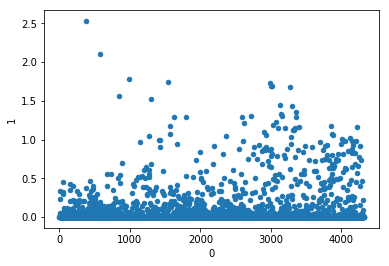

In [38]:
x_range = np.array(range(0,cnn_code_layer_size))

code_frame = pd.DataFrame([x_range,code[0]]).transpose()

from matplotlib import pyplot as plt
code_frame.plot(kind='scatter', x=0, y=1)
plt.axis('on')
plt.savefig('AE_Code.jpeg')
plt.show()

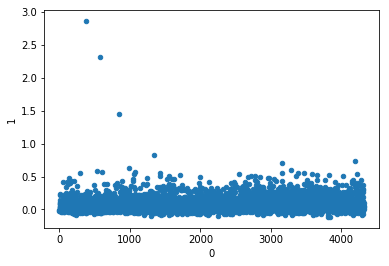

In [39]:
x_range = np.array(range(0,cnn_code_layer_size))

code_frame = pd.DataFrame([x_range,decode[0]]).transpose()

from matplotlib import pyplot as plt
code_frame.plot(kind='scatter', x=0, y=1)
plt.axis('on')
plt.savefig('AE_DeCode.jpeg')
plt.show()

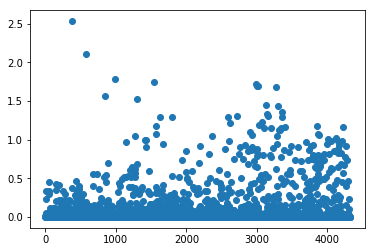

In [109]:
#Look at the code as a graph of tensor values coming out

from matplotlib import pyplot as plt
plt.scatter(range(0,cnn_code_layer_size),code[0])
plt.axis('on')
plt.savefig('original_code.jpeg')
plt.show()

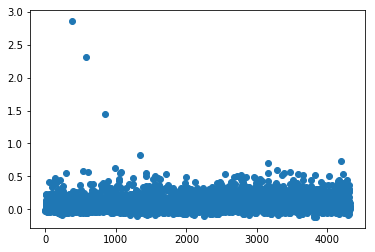

In [110]:
#Compare to the decode as a graph of tensor values

from matplotlib import pyplot as plt
plt.scatter(range(0,cnn_code_layer_size),decode[0])
plt.axis('on')
plt.savefig('recovered_code.jpeg')
plt.show()

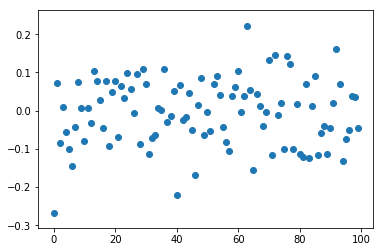

1

In [111]:
#Compare to the decode as a graph of tensor values

from matplotlib import pyplot as plt
plt.scatter(range(0,100),encode[0])
plt.axis('on')
plt.savefig('condensed_code.jpeg')
plt.show()
cat[0]

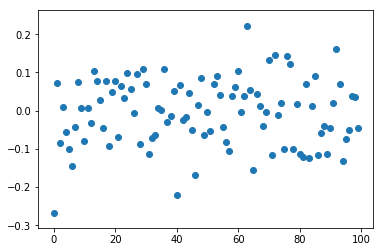

1

In [112]:
#Compare to the decode as a graph of tensor values

from matplotlib import pyplot as plt
plt.scatter(range(0,100),encode[0])
plt.axis('on')
plt.show()
cat[0]

# Test the classifier

Here we need to test to see that the classifier does a decent job of capturing the original data

In [113]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list, batch_size: 30, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    accuracy_val, loss, guess, truth = sess.run([accuracy, loss_cat, max_softmax_val, y], 
                                            feed_dict={handle:val_handle, training:False})
                    
loss

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_best


0.00013701306

In [114]:
accuracy_val

1.0

In [115]:
guess

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0])

In [116]:
truth

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 0])

# Test the tan
Here we need to test to see that the tan does a decent job of capturing the likelihood

In [141]:
#Load model

with tf.Session() as sess:
    #Restore File
    saver_tan.restore(sess, out_of_set_net_best)
    
    #initialize iterator
    sess.run(val_iterator.initializer, feed_dict={filename: val_list_all, batch_size: 30, num_epochs:1})
    val_handle = sess.run(val_iterator.string_handle())
    
    loss, guess, truth, like_loss, like = sess.run([loss_cat, max_softmax_val, y, tan_loss, tan_likelihoods], 
                                            feed_dict={handle: val_handle, training: False})
                    
like_loss

INFO:tensorflow:Restoring parameters from D:/AI/models/out_of_set_net_v2/final_model/out_of_set_net_best


32.685883

In [146]:
like

array([  36.58279419,   -5.44273376,  -75.0509491 ,  -54.78034973,
         70.54601288,  -85.98786926, -116.56011963,  -60.25465393,
        -14.78108215,  -25.71965027,  -44.01971436,  -82.65281677,
         25.28877258,  -39.46548462,  -52.06677246,   53.42056274,
        -75.34771729,   63.05776978,  -90.73979187,  -19.86929321,
        -38.54089355,  -27.08026123,   76.8298645 ,  -96.05683899,
       -107.55592346,  -19.21969604,  -70.42738342,  -75.97698975,
        -93.41203308,   64.70675659], dtype=float32)

In [147]:
truth

array([4, 6, 4, 7, 9, 5, 3, 5, 7, 7, 4, 6, 1, 5, 5, 4, 5, 0, 2, 5, 4, 1, 0,
       2, 5, 4, 5, 1, 8, 9])

In [130]:
data = np.array(like,truth)


TypeError: data type not understood

In [123]:
data = pd.DataFrame(data,columns=['true_class','likelihood'])

,0
4,36.582794
6,-5.442734
4,-75.050949
7,-54.780350
9,70.546013
5,-85.987869
3,-116.560120
5,-60.254654
7,-14.781082
7,-25.719650


In [ ]:
#Correct Answer
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_array, y=y_array, c='r', s=40)
plt.axis('on')
plt.show()

In [ ]:
#Guess
from matplotlib import pyplot as plt
plt.imshow(x_val, interpolation='nearest')
plt.scatter(x=x_guess, y=y_guess, c='r', s=40)
plt.axis('on')
plt.show()

In [ ]:
loss_val

In [ ]:
with tf.Session() as sess:
    #restore graph from meta and restore variables
    new_saver = tf.train.import_meta_graph(out_of_set_net_best + '.meta')
    new_saver.restore(sess, out_of_set_net_best)
    soft = tf.get_default_graph().get_tensor_by_name("Out_Of_Set_Classifier/Final_Layer/final_soft_max:0")
    input_tensor = tf.get_default_graph().get_tensor_by_name("input:0")
    val = soft.eval(feed_dict={input_tensor: cat, training: False})

In [ ]:
current_step


In [ ]:
image_net_dict_file

In [ ]:
frame

In [ ]:
list = np.reshape(last_layers, (num_epochs,batch_size,4320))

In [ ]:
list

In [ ]:
with tf.Session() as sess:
    #restore saver, build iterator, set the step to the global step
    saver2.restore(sess, out_of_set_net_model)
    
    #Set up the global steps
    total_steps = tf.train.global_step(sess, global_step)
    
    print("Did " + str(total_steps) + " of loss minimized training in " + str(final_time) + " time.")
    print("Done!")

In [ ]:
final_time